In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

In [2]:
from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries

In [74]:

# @torch.jit.script
def evalArea(arg: Union[float, torch.Tensor], packing, dtype, device : torch.device, targetNeighbors : int, kernel, dim = 2):
    
    arg = arg if isinstance(arg, torch.Tensor) else torch.tensor(arg if isinstance(arg, float) or isinstance(arg, int) else 0.0, dtype = dtype, device = device)
    support = volumeToSupport(arg, targetNeighbors, dim)
    
    minDomain = torch.tensor([-1.1 * support] * dim, device = device, dtype = dtype)
    maxDomain = torch.tensor([1.1 * support] * dim, device = device, dtype = dtype)
    
    ii = torch.arange(maxDomain[0] / packing, device = device)
    ii = torch.hstack((ii.flip(0), ii[1:]))
    xx = (ii * packing)
    
    # print('xx', xx.shape)
    
    p = xx.view(-1,1)
    if dim == 2:    
        xx, yy = torch.meshgrid(xx,xx, indexing = 'xy')
        p = torch.stack((xx,yy), dim = -1).flatten(0,1)
    elif dim == 3:
        xx, yy, zz = torch.meshgrid(xx,xx, xx, indexing = 'xy')
        p = torch.stack((xx,yy, zz), dim = -1).flatten(0,2)
    
    rij = torch.linalg.norm(p, dim = -1)
    rij = rij[rij < support]
    k = arg * torch.sum(kernel.kernel(rij / support, torch.ones_like(rij) * support, dim))
    
    return k

    # return ((1 - rho)**2).detach().cpu().numpy()[0]

def optimizeArea(arg: Union[float, torch.Tensor], packing, dtype, device : torch.device, targetNeighbors : int, kernel, dim = 2, thresh = 1e-7, maxIter = 32):
    arg = arg if isinstance(arg, torch.Tensor) else torch.tensor(arg if isinstance(arg, float) or isinstance(arg, int) else 0.0, dtype = dtype, device = device)
    loss = 1
    for i in range(maxIter):
        arg.requires_grad = True
        eval = evalArea(arg, packing, torch.float32, 'cpu', targetNeighbors, kernel, dim)
        loss = (1-eval)**2
        loss.backward()
        arg = (arg - arg * arg.grad / targetNeighbors * 1e-3).detach()
        # print(f'iter: {i}: \tloss: {loss}, arg: {arg}')
        if loss < thresh:
            break
    # print('arg', arg)
    eval = evalArea(arg, packing, torch.float32, 'cpu', targetNeighbors, kernel, dim)
    # print('eval', eval, (1-eval)**2)
    return arg, eval, (1-eval)**2
    # print(eval)

from typing import List
def sampleRegular(
        dx: float = 2/32, dim: int = 2,
        minExtent : float | List[float] = -1, maxExtent : float | List[float] = 1, 
        
        targetNeighbors : int = 50, correctedArea : bool = False, kernel = None):
    minDomain = torch.tensor([minExtent] * dim).to(torch.float32) if isinstance(minExtent, float) or isinstance(minExtent, int) else torch.tensor(minExtent).to(torch.float32)
    maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)
    # dim = minDomain.shape[0]
    # dx = (maxDomain[0] - minDomain[0]) / nx          
    area = dx**(dim)
    # print(area)
    
    if correctedArea:
        area, *_ = optimizeArea(area, dx, torch.float64, 'cpu', targetNeighbors, kernel, dim = dim, thresh = 1e-7**2, maxIter = 64)
    ns = [torch.ceil((maxDomain[i] - minDomain[i]) / dx).to(torch.long) for i in range(dim)]
    lins = [torch.linspace(minDomain[i] + dx / 2, maxDomain[i] - dx/2, ns[i]) for i in range(dim)]
    grid = torch.meshgrid(*lins, indexing = 'xy')
    p = torch.stack(grid, dim = -1).flatten(0,-1).view(-1,dim)

    return p, area

In [75]:
minExtent = -1
maxExtent = 1
nx = 128
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True

from diffSPH.v2.math import volumeToSupport

# 1D Plot

In [76]:
minExtent = -1
maxExtent = 1
nx = 128
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 1
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)
# print(volume, volume, h)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=True, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)
# print(ni)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 

/tmp/ipykernel_15064/3889422498.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)


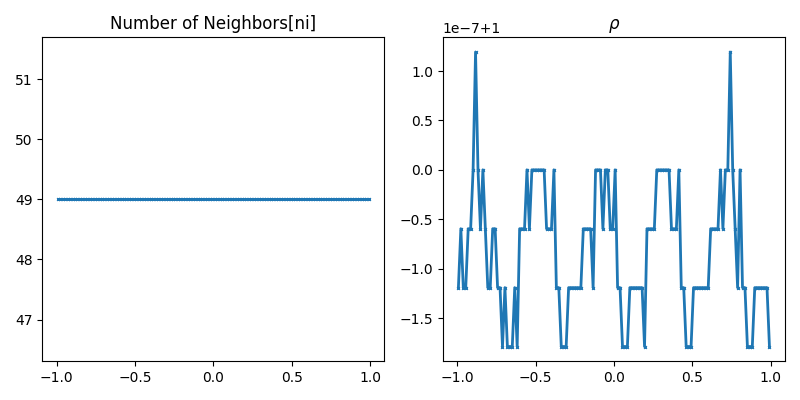

In [86]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.plot(p[:,0], c, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)

scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
# print(rho)

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

# 2D Plot

In [87]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=periodic, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 


/tmp/ipykernel_15064/3889422498.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)


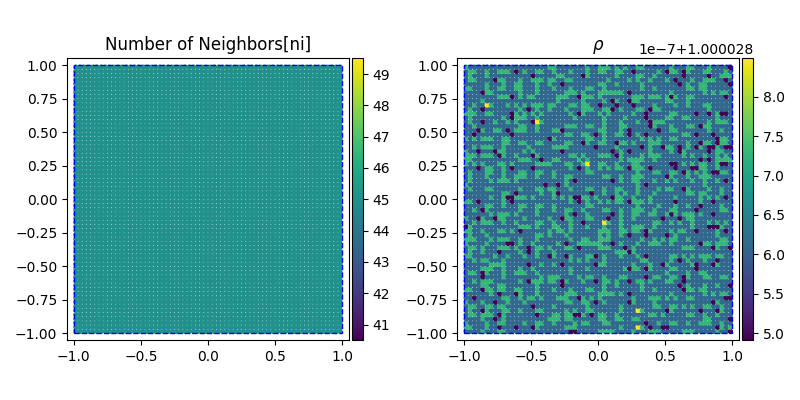

In [89]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.scatter(p[:,0], p[:,1], s = 8, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

# 3D Plot

In [90]:
minExtent = -1
maxExtent = 1
nx = 32
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 3
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=periodic, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 

/tmp/ipykernel_15064/3889422498.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)


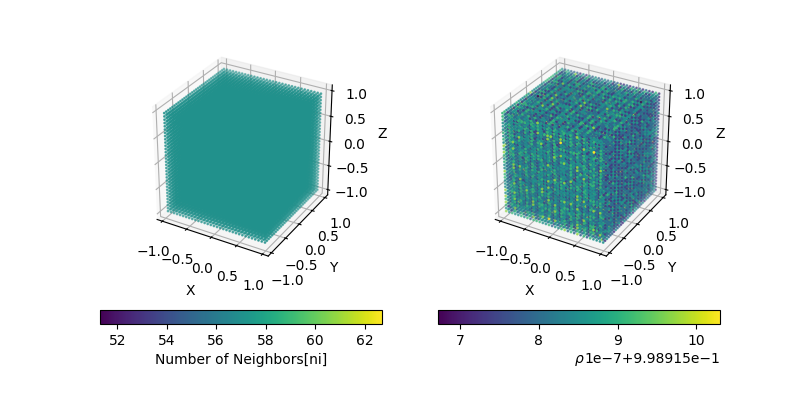

In [91]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(p[:, 0], p[:, 1], p[:, 2], s = 1, c = ni)
fig.colorbar(sc, ax=ax, orientation='horizontal', label='Number of Neighbors[ni]', location = 'bottom')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(p[:, 0], p[:, 1], p[:, 2], s = 1, c = rho)
fig.colorbar(sc, ax=ax, orientation='horizontal', label='$\\rho$', location = 'bottom')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')


plt.show()


In [ ]:
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

# Define your PDF
def pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

# Generate x values
x = np.linspace(-10, 10, 1000)

# Compute the CDF using numerical integration
cdf = cumtrapz(pdf(x), x, initial=0)

# Interpolate the inverse CDF
inverse_cdf = interp1d(cdf, x)

# Now you can use inverse_cdf to compute the inverse CDF for any value

In [27]:
print(regular)

[tensor([-0.9688, -0.9062, -0.8438, -0.7812, -0.7188, -0.6562, -0.5938, -0.5312,
        -0.4688, -0.4062, -0.3438, -0.2812, -0.2188, -0.1562, -0.0938, -0.0312,
         0.0312,  0.0938,  0.1562,  0.2188,  0.2812,  0.3438,  0.4062,  0.4688,
         0.5312,  0.5938,  0.6562,  0.7188,  0.7812,  0.8438,  0.9062,  0.9688]), tensor([-0.9688, -0.9062, -0.8438, -0.7812, -0.7188, -0.6562, -0.5938, -0.5312,
        -0.4688, -0.4062, -0.3438, -0.2812, -0.2188, -0.1562, -0.0938, -0.0312,
         0.0312,  0.0938,  0.1562,  0.2188,  0.2812,  0.3438,  0.4062,  0.4688,
         0.5312,  0.5938,  0.6562,  0.7188,  0.7812,  0.8438,  0.9062,  0.9688])]


In [7]:
# Function to sample particles such that their density equals a desired PDF
def samplePDF(pdf, n = 2048, numParticles = 1024, plot = False, randomSampling = False):
    x = np.linspace(-1,1,n)
    if plot:
        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

    xs = np.linspace(-1,1,n)

    if plot:
        axis[0,0].plot(xs, pdf(xs))

    normalized_pdf = lambda x: pdf(x) / np.sum(pdf(np.linspace(-1,1,n)))
    if plot:
        axis[0,0].plot(xs, normalized_pdf(xs))
        axis[0,0].axhline(0,ls= '--', color = 'black')


    xs = np.linspace(-1,1,n)
    fxs = normalized_pdf(xs)
    sampled_cdf = np.cumsum(fxs) - fxs[0]
    sampled_cdf = sampled_cdf / sampled_cdf[-1] 
    inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

    samples = np.random.uniform(size = numParticles)
    if not randomSampling:
        samples = np.linspace(0,1,numParticles, endpoint=False)
    sampled = inv_cdf(samples)

    return torch.tensor(sampled, dtype = torch.float32).view(-1,1)

In [8]:
pdf = lambda x: np.sin(x * np.pi * 4) + 2

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


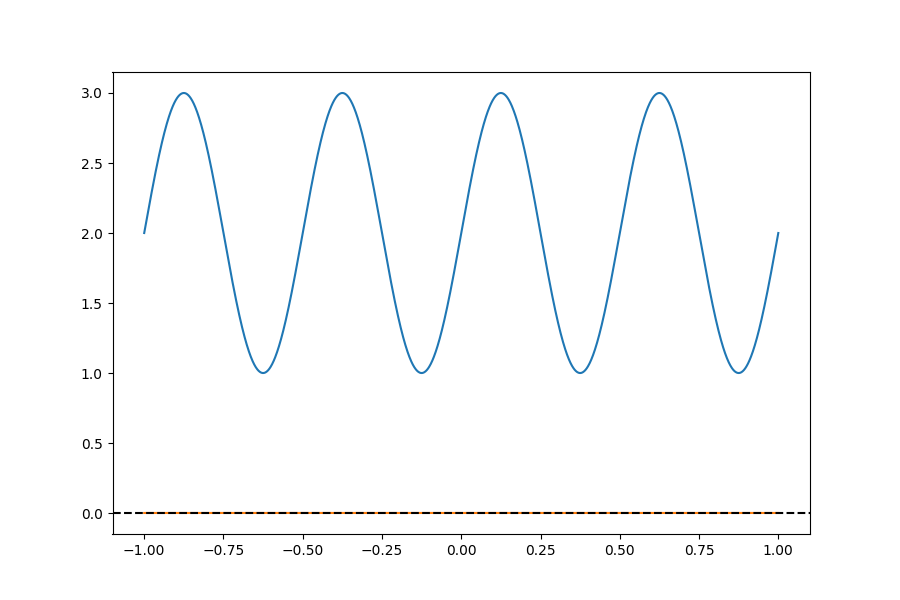

In [9]:
sampled = samplePDF(pdf, n = 2048, numParticles = 1024, plot = True, randomSampling = False)

In [12]:
from torchCompactRadius import radiusSearch, volumeToSupport

In [ ]:
extent = 

h = volumeToSupport()

In [7]:
def scatterPlot(fig, axis, pos_x, s, c, cmap = 'viridis', title = None):
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = c.detach().cpu().numpy(), cmap = cmap)

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cb.ax.tick_params(labelsize=8)
    axis.axis('equal')
    axis.set_xlim(minDomain[0], maxDomain[0])
    axis.set_ylim(minDomain[1], maxDomain[1])
    if title is not None:
        axis.set_title(title)

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


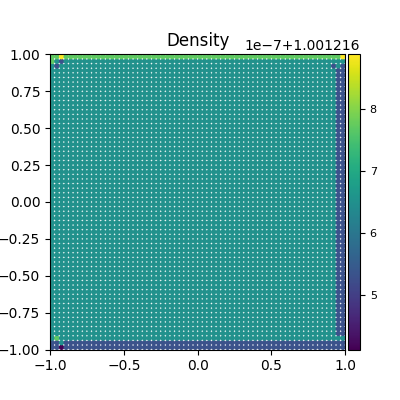

In [78]:
dim = 2
periodicity = [True] * dim
minDomain = [-1] * dim
maxDomain = [ 1] * dim
Kernel = getKernel('Wendland2')
nx = 64
targetNeighbors = 50
dx = (maxDomain [0] - minDomain[0]) / nx
vol = dx ** dim
h = volumeToSupport(vol, targetNeighbors, dim)


x = sampleRegular(nx, minDomain, maxDomain, targetNeighbors, False, Kernel)
hx = torch.ones(x.shape[0]) * h
areas = torch.ones(x.shape[0]) * vol


i, j, rij, xij, hij = neighborSearch(x, x, hx, hx, periodicity, minDomain, maxDomain)
kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)

rho = sphOperation((areas, areas), (areas, areas), (areas, areas), (i, j), kernel, gradKernel, 
                   rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')

fig, axis = plt.subplots(1, 1, figsize=(4,4), sharex = True, sharey = True, squeeze = False)
scatterPlot(fig, axis[0,0], x, 8, rho, 'viridis', 'Density')



In [89]:
from matplotlib.path import Path
from skimage.draw import polygon2mask
from scipy.ndimage import distance_transform_edt

def polygonToSDF(polygon, minDomain = [-1, -1], maxDomain = [1,1], sdfResolution = 128):
    scale_x = sdfResolution / (maxDomain[0] - minDomain[0])
    scale_y = sdfResolution / (maxDomain[1] - minDomain[1])
    scale = max(scale_x, scale_y)

    scaledPolygon = (polygon - np.array(minDomain)) * scale
    mask = polygon2mask((sdfResolution, sdfResolution), scaledPolygon)
    inside_distance = distance_transform_edt(mask)
    outside_distance = distance_transform_edt(1 - mask)
    signed_distance = outside_distance - inside_distance

    return signed_distance / scale

def maskWithSDF(x, sdf, minDomain, maxDomain):
    sdf_query = lambda x, sdf, minDomain, maxDomain: sdf[int((x[1] - minDomain[1]) / (maxDomain[1] - minDomain[1]) * sdf.shape[0]), int((x[0] - minDomain[0]) / (maxDomain[0] - minDomain[0]) * sdf.shape[1])]
    distances = torch.tensor([sdf_query(p, sdf, minDomain, maxDomain) for p in x.detach().cpu().numpy()])
    mask = distances < 0
    return mask, distances

def maskWithPolygon(x, polygon):
    path = Path(polygon)
    mask = torch.tensor(path.contains_points(x.detach().cpu().numpy()))
    return mask

def maskWithFunction(x, implicitFunction):
    mask = implicitFunction(x) < 0
    return mask

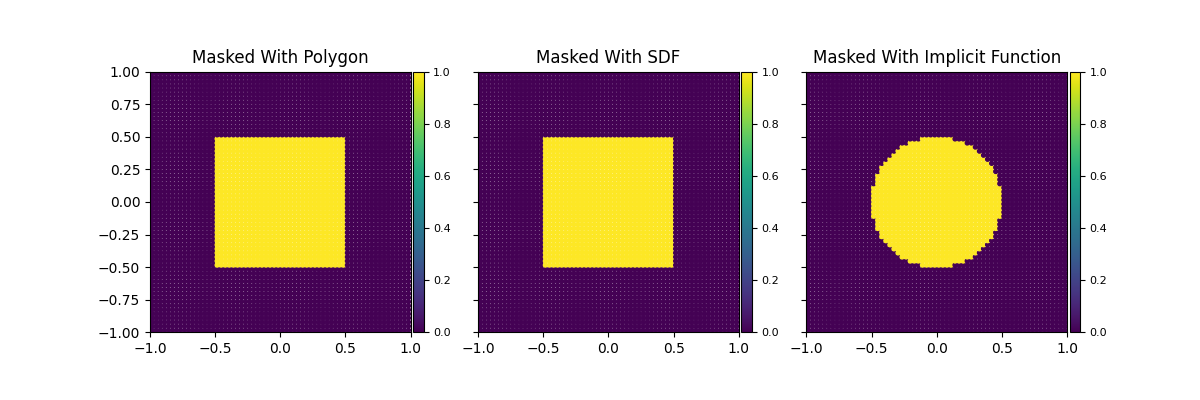

In [100]:
polygon = np.array([[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]])

mask = maskWithPolygon(x, polygon)
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)
scatterPlot(fig, axis[0,0], x, 8, mask, 'viridis', 'Masked With Polygon')

nsdf = 128
sdf = polygonToSDF(polygon, minDomain, maxDomain, nsdf)
mask, _ = maskWithSDF(x, sdf, minDomain, maxDomain)
scatterPlot(fig, axis[0,1], x, 8, mask, 'viridis', 'Masked With SDF')

def implicitFunction(x):
    return x[:,0] ** 2 + x[:,1] ** 2 - 0.5 ** 2
scatterPlot(fig, axis[0,2], x, 8, maskWithFunction(x, implicitFunction), 'viridis', 'Masked With Implicit Function')


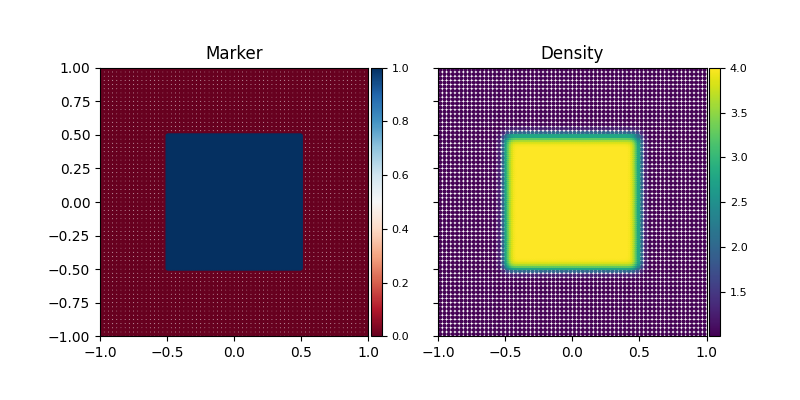

In [118]:
dim = 2
periodicity = [True] * dim
minDomain = [-1] * dim
maxDomain = [ 1] * dim
Kernel = getKernel('Wendland2')
nx = 64
targetNeighbors = 50
dx = (maxDomain [0] - minDomain[0]) / nx
vol = dx ** dim
h = volumeToSupport(vol, targetNeighbors, dim)


x = sampleRegular(nx, minDomain, maxDomain, targetNeighbors, False, Kernel)
hx = torch.ones(x.shape[0]) * h
areas = torch.ones(x.shape[0]) * vol


# i, j, rij, xij, hij = neighborSearch(x, x, hx, hx, periodicity, minDomain, maxDomain)
# kernel = Kernel.kernel(rij, hij)
# gradKernel = Kernel.kernelGradient(rij, xij, hij)

# rho = sphOperation((areas, areas), (areas, areas), (areas, areas), (i, j), kernel, gradKernel, 
#                    rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')
mask = maskWithFunction(x, lambda x: 
                        torch.where(
                            torch.ge(x[:,0], -0.5) & torch.le(x[:,0], 0.5)& \
                            torch.ge(x[:,1], -0.5) & torch.le(x[:,1], 0.5), 1, -1) )
x = x[mask]
hx = hx[mask]
areas = areas[mask]
marker = torch.ones(x.shape[0]) * 0
# print(mask)

x2 = sampleRegular(nx * 2, minDomain, maxDomain, targetNeighbors, False, Kernel)
hx2 = torch.ones(x2.shape[0]) * h
areas2 = torch.ones(x2.shape[0]) * vol
mask2 = maskWithFunction(x2, lambda x: 
                        torch.where(
                            torch.ge(x[:,0], -0.5) & torch.le(x[:,0], 0.5)& \
                            torch.ge(x[:,1], -0.5) & torch.le(x[:,1], 0.5), -1, 1) )
x2 = x2[mask2]
hx2 = hx2[mask2]
areas2 = areas2[mask2]
marker2 = torch.ones(x2.shape[0]) * 1

x = torch.cat([x, x2])
hx = torch.cat([hx, hx2])
areas = torch.cat([areas, areas2])
marker = torch.cat([marker, marker2])

fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = True, sharey = True, squeeze = False)
scatterPlot(fig, axis[0,0], x, 8, marker, 'RdBu', 'Marker')


i, j, rij, xij, hij = neighborSearch(x, x, hx, hx, periodicity, minDomain, maxDomain, mode = 'symmetric')
kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)

rho = sphOperation((areas, areas), (areas, areas), (areas, areas), (i, j), kernel, gradKernel, 
                   rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')

# fig, axis = plt.subplots(1, 1, figsize=(4,4), sharex = True, sharey = True, squeeze = False)
scatterPlot(fig, axis[0,1], x, 4, rho, 'viridis', 'Density')


/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


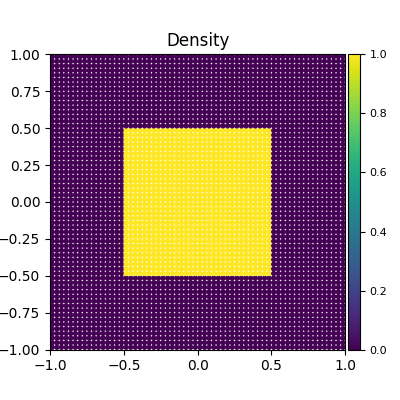

In [88]:

polygon = np.array([[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]])


# Query the SDF using minDomain and maxDomain as bounds with x
# x = [0.2, 0.3]  # Replace with your desired x coordinates
# sdf_value = sdf[int((x[1] - minDomain[1]) / (maxDomain[1] - minDomain[1]) * nx), int((x[0] - minDomain[0]) / (maxDomain[0] - minDomain[0]) * nx)]

# distances = torch.tensor([sdf_query(p, sdf, minDomain, maxDomain) for p in x.detach().cpu().numpy()])


mask, _ = maskWithSDF(x, sdf, minDomain, maxDomain)

fig, axis = plt.subplots(1, 1, figsize=(4,4), sharex = True, sharey = True, squeeze = False)
scatterPlot(fig, axis[0,0], x, 8, mask, 'viridis', 'Density')



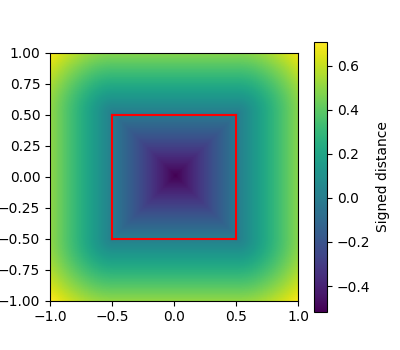

In [65]:

signed_distance = polygonToSDF(polygon, minDomain, maxDomain, 128) 

fig, axis = plt.subplots(1, 1, figsize=(4,3.5), sharex = True, sharey = True, squeeze = False)

for i, ll in enumerate(polygon):
    l = polygon[i]
    ln = polygon[(i + 1) % len(polygon)]
    axis[0,0].plot([l[0], ln[0]], [l[1], ln[1]], 'r')

im = axis[0,0].imshow(signed_distance, extent=(minDomain[0], maxDomain[0], minDomain[1], maxDomain[1]), origin='lower', cmap = 'viridis')
fig.colorbar(im, label='Signed distance')

In [27]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.draw import polygon2mask

# Define the polygon as a set of lines
polygon = np.array([[0.5, 0.5], [1, 0], [1, 1], [0, 1]])

# Create a binary mask of the polygon
mask = polygon2mask((500, 500), polygon * 500)

# Compute the signed distance field
from scipy.ndimage import distance_transform_edt
inside_distance = distance_transform_edt(mask)
outside_distance = distance_transform_edt(1 - mask)
signed_distance = inside_distance - outside_distance

# Plot the signed distance field
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 1, figsize=(4,4), sharex = True, sharey = True, squeeze = False)
im =  axis[0,0].imshow(signed_distance, extent=(-1, 2, -1, 2), origin='lower')

for l in polygon:
    axis[0,0].plot([l[0], l[1]], [l[1], l[1]], 'r')

# plt.imshow(signed_distance, extent=(-1, 2, -1, 2), origin='lower')
fig.colorbar(im, label='Signed distance')
# plt.show()

In [ ]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()


In [ ]:
from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import kernel


nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')


In [ ]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
# timesteps = 4096 * 4
# # timesteps = 2424
# for i in tqdm(range(timesteps)):
#     sphSimulation.integrate()
# #     break
# #     sphSimulation.timestep()
#     if i  % 64 == 0 or i == timesteps - 1:
# #     if True:
#         state = sphSimulation.simulationState        

#         updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
#         fig.canvas.draw()
#         fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         # plt.savefig(imagePath)

In [ ]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
timesteps = 512
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, None, pMeshX, pMeshY, pMeshN, None, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        # imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
from diffSPH.v2.neighborhood import neighborSearch

In [ ]:
# @torch.jit.script
# def wendland4(q, h):
#     C = 7 / np.pi
#     b1 = torch.pow(1. - q, 4)
#     b2 = 1.0 + 4.0 * q
#     return b1 * b2 * C / h**2  
# @torch.jit.script
# def wendland4Grad(q,r,h):
#     C = 7 / np.pi    
#     return - r * C * (20. * q * (1. -q)**3/ h**3 )[:,None]

In [ ]:
Kernel = getKernel('Wendland2')

positions = sphSimulation.simulationState['fluidPosition']

x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

i, j, rij, xij, hij = neighborSearch(x, y, hx, hy, [periodicX, periodicY], minDomain, maxDomain)

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)

In [ ]:

@torch.jit.script
def mod(x, min : float, max : float):
    return torch.where(torch.abs(x) > (max - min) / 2, torch.sgn(x) * ((torch.abs(x) + min) % (max - min) + min), x)


periodicity = [True, False]
pos_x = x
pos_y = y

pos_x = torch.stack([x[:,i] if not periodic else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic in enumerate(periodicity)], dim = 1)
distanceMatrices = torch.stack([pos_x[:,i] - pos_y[:,i,None] if not periodic else mod(pos_x[:,i] - pos_y[:,i,None], minDomain[i], maxDomain[i]) for i, periodic in enumerate(periodicity)], dim = -1)
distanceMatrix = torch.sqrt(torch.sum(distanceMatrices**2, dim = -1))
mode = 'gather'
indexI, indexJ = torch.meshgrid(torch.arange(x.shape[0]).to(x.device), torch.arange(y.shape[0]).to(y.device), indexing = 'xy')
if mode == 'gather':        
    gatherMatrix = hx.repeat(hy.shape[0],1)
    adjacencyDense = distanceMatrix <= gatherMatrix
    supports = gatherMatrix[adjacencyDense]
elif mode == 'scatter':        
    scatterMatrix = hy.repeat(hx.shape[0],1).mT
    adjacencyDense = distanceMatrix <= scatterMatrix
    supports = scatterMatrix[adjacencyDense]
else:
    symmetricMatrix = (hx + hy[:,None]) / 2
    adjacencyDense = distanceMatrix <= symmetricMatrix
    supports = symmetricMatrix[adjacencyDense]

ii = indexI[adjacencyDense]
jj = indexJ[adjacencyDense]

distanceMatrices[adjacencyDense]

In [ ]:


# from typing import Dict, Optional
# # ------ Beginning of scatter functionality ------ #
# # Scatter summation functionality based on pytorch geometric scatter functionality
# # This is included here to make the code independent of pytorch geometric for portability
# # Note that pytorch geometric is licensed under an MIT licenses for the PyG Team <team@pyg.org>
# @torch.jit.script
# def broadcast(src: torch.Tensor, other: torch.Tensor, dim: int):
#     if dim < 0:
#         dim = other.dim() + dim
#     if src.dim() == 1:
#         for _ in range(0, dim):
#             src = src.unsqueeze(0)
#     for _ in range(src.dim(), other.dim()):
#         src = src.unsqueeze(-1)
#     src = src.expand(other.size())
#     return src

# @torch.jit.script
# def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
#                 out: Optional[torch.Tensor] = None,
#                 dim_size: Optional[int] = None) -> torch.Tensor:
#     index = broadcast(index, src, dim)
#     if out is None:
#         size = list(src.size())
#         if dim_size is not None:
#             size[dim] = dim_size
#         elif index.numel() == 0:
#             size[dim] = 0
#         else:
#             size[dim] = int(index.max()) + 1
#         out = torch.zeros(size, dtype=src.dtype, device=src.device)
#         return out.scatter_add_(dim, index, src)
#     else:
#         return out.scatter_add_(dim, index, src)
# # ------ End of scatter functionality ------ #


In [ ]:
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.sphOps import *

In [ ]:

# def sphInterpolation(fluidMasses, fluidDensities, fluidQuantities, fluidNeighbors, fluidKernels, fluidKernelGradients, numParticles):
#     i = fluidNeighbors[0]
#     j = fluidNeighbors[1]
#     return scatter_sum(fluidMasses[1][j] / fluidDensities[1][j] * fluidQuantities[1][j] * fluidKernels, i, dim = 0, dim_size = numParticles)

In [ ]:
torch.linalg.norm(xij, dim = -1)

In [ ]:

x = torch.clone(positions)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
h = torch.max(hx).item() * 2
area = sphSimulation.simulationState['fluidArea']


minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

if periodicX and not periodicY:
    pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
elif not periodicX and periodicY:
    pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
elif periodicX and periodicY:
    pos_x = torch.remainder(x - minD, maxD - minD) + minD
else:
    pos_x = x  
rho = sphSimulation.perennialState['fluidDensity']
q = torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi)

q[:] = 1

In [ ]:
masses = (area, area)
densities = (rho, rho)
quantities = (q, q)
neighborhood = (i, j)
kernels = kernel
gradKernels = gradKernel
laplacianKernels = Kernel.kernelLaplacian(rij, hij, dim = 2)
laplacianKernels[rij < 1e-3] = laplacianKernels.max()

q = torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi)
qv = torch.stack((torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi), torch.sin(pos_x[:,0] * np.pi) * torch.cos(pos_x[:,1] * np.pi) ), dim = 1)
rv = torch.stack((torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi), torch.sin(pos_x[:,0] * np.pi) * torch.cos(pos_x[:,1] * np.pi) ), dim = 1)
cv = torch.stack((torch.cos(pos_x[:,1] * np.pi) * torch.sin(pos_x[:,0] * np.pi), torch.sin(pos_x[:,1] * np.pi) * torch.cos(pos_x[:,0] * np.pi) ), dim = 1)
qm = torch.stack((rv, cv), dim = 1)



In [ ]:
def scatterPlot(fig, axis, pos_x, s, c, cmap = 'viridis', title = None):
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = c.detach().cpu().numpy(), cmap = cmap)

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cb.ax.tick_params(labelsize=8)
    axis.axis('equal')
    axis.set_xlim(minDomain[0], maxDomain[0])
    axis.set_ylim(minDomain[1], maxDomain[1])
    if title is not None:
        axis.set_title(title)


x = torch.clone(positions)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
h = torch.max(hx).item() * 1.245
area = sphSimulation.simulationState['fluidArea']


minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

if periodicX and not periodicY:
    pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
elif not periodicX and periodicY:
    pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
elif periodicX and periodicY:
    pos_x = torch.remainder(x - minD, maxD - minD) + minD
else:
    pos_x = x  
    


i, j, rij, xij, hij = neighborSearch(x, x, h, h, [True, True], minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)
laplacianKernels = Kernel.kernelLaplacian(rij, hij, dim = 2)
# laplacianKernels[rij < 1e-3] = 0#laplacianKernels.max()




# area.requires_grad = True
density = sphInterpolation((None,area), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, x.shape[0])
rho = sphSimulation.perennialState['fluidDensity']


In [ ]:
# err = torch.abs(torch.mean(density) - 1)

In [ ]:
# print(err)

In [ ]:
# gradientType = 'gradientSymmetric'
gradientType = 'difference'
# gradientType = 'gradientSummation'
# gradientType = 'gradientNaive'

In [ ]:
# err.backward()

In [ ]:
ii, ni =torch.unique(i, return_counts = True)
print(ni)

In [ ]:
q = torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi)
q = torch.abs(pos_x[:,0] / 16)**2
q = torch.sin(pos_x[:,0] * np.pi)
interpolatedNaive = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
                    operation = 'laplacian', gradientMode = 'naive', kernelLaplacians = laplacianKernels)
grad = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
                    operation = 'gradient', gradientMode = 'difference', kernelLaplacians = laplacianKernels)

fig, axis = plt.subplots(2, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
fig.suptitle('Interpolation Operation')
scatterPlot(fig, axis[0,0], pos_x, 4, q, 'viridis', title = 'q')
scatterPlot(fig, axis[0,1], pos_x, 4, grad[:,0], 'viridis', title = 'grad[:,0]')
scatterPlot(fig, axis[0,2], pos_x, 4, grad[:,1], 'viridis', title = 'grad[:,1]')

scatterPlot(fig, axis[1,0], pos_x, 4, interpolatedNaive, 'viridis', title = 'naive Laplace')

interpolatedNormal = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
                    operation = 'laplacian', gradientMode = 'naive', kernelLaplacians = laplacianKernels)
# scatterPlot(fig, axis[1,1], pos_x, 4, interpolatedNormal, 'viridis', title = 'Laplacian')

print(interpolatedNormal.max(), np.pi**2, interpolatedNormal.max() / np.pi**2)

        # grad = sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
        # div = sphDivergence(masses, densities, (grad, grad), neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)

div = sphOperation((area, area), (rho, rho), (grad, grad), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
                    operation = 'divergence', gradientMode = 'naive', kernelLaplacians = laplacianKernels)

qq = torch.vstack((q, torch.zeros_like(q))).mT
# qq = torch.vstack((q, q)).mT

interpolated = sphOperation((area, area), (rho, rho), (qq, qq), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
                    operation = 'laplacian', gradientMode = 'divergenceFree', kernelLaplacians = laplacianKernels)
print(interpolated.shape)
scatterPlot(fig, axis[1,1], pos_x, 4, interpolated[:,0], 'viridis', title = 'direct Laplacian[:,0]')
scatterPlot(fig, axis[1,2], pos_x, 4, interpolated[:,1], 'viridis', title = 'direct Laplacian[:,1]')
fig.tight_layout()

In [ ]:
qq.shape

In [ ]:
print(interpolatedNormal)
print(interpolated)
print(interpolatedNormal / interpolated[:,0])
print(torch.mean(interpolatedNormal / interpolated[:,0]))

## Scalar in operations:

In [ ]:
q = torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi)

# q[:] = 1
interpolated = sphOperation((None, area), (None, rho), (None, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'interpolate')
gradient = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'gradient', gradientMode = 'difference')

fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
fig.suptitle('Interpolation Operation')
scatterPlot(fig, axis[0,0], pos_x, 4, q, 'viridis', title = 'q')
scatterPlot(fig, axis[0,1], pos_x, 4, interpolated, 'viridis', title = 'interpolated')
fig.tight_layout()

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
fig.suptitle('Gradient Operation')
scatterPlot(fig, axis[0,0], pos_x, 4, q, 'viridis', title = 'q')
scatterPlot(fig, axis[0,1], pos_x, 4, gradient[:,0], 'viridis', title = 'gradient[:,0]')
scatterPlot(fig, axis[0,2], pos_x, 4, gradient[:,1], 'viridis', title = 'gradient[:,1]')
fig.tight_layout()

# gradient = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'divergence', gradientMode = 'difference')

## Vector in operations:

In [ ]:
q = torch.cos(pos_x[:,0])
q = torch.stack((torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi),- torch.sin(pos_x[:,0] * np.pi) * torch.cos(pos_x[:,1] * np.pi) ), dim = 1)

# q = pos_x * (torch.linalg.norm(pos_x , dim = -1)).view(-1,1)

interpolated = sphOperation((None, area), (None, rho), (None, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'interpolate')
gradient = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'gradient', gradientMode = 'difference')

# fig, axis = plt.subplots(2, 2, figsize=(8,8), sharex = False, sharey = False, squeeze = False)
# fig.suptitle('Interpolation Operation')
# scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0], 'viridis', title = 'q[:,0]')
# scatterPlot(fig, axis[1,0], pos_x, 4, q[:,1], 'viridis', title = 'q[:,1]')
# scatterPlot(fig, axis[0,1], pos_x, 4, interpolated[:,0], 'viridis', title = 'interpolated[:,0]')
# scatterPlot(fig, axis[1,1], pos_x, 4, interpolated[:,1], 'viridis', title = 'interpolated[:,1]')
# fig.tight_layout()

# fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)
# fig.suptitle('Gradient Operation')
# scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0], 'viridis', title = 'q[:,0]')
# scatterPlot(fig, axis[1,0], pos_x, 4, q[:,1], 'viridis', title = 'q[:,1]')
# scatterPlot(fig, axis[0,1], pos_x, 4, gradient[:,0,0], 'viridis', title = 'gradient[:,0,0]')
# scatterPlot(fig, axis[0,2], pos_x, 4, gradient[:,0,1], 'viridis', title = 'gradient[:,0,1]')
# scatterPlot(fig, axis[1,1], pos_x, 4, gradient[:,1,0], 'viridis', title = 'gradient[:,1,0]')
# scatterPlot(fig, axis[1,2], pos_x, 4, gradient[:,1,1], 'viridis', title = 'gradient[:,1,1]')
# fig.tight_layout()

divergence = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'divergence', gradientMode = 'symmetric')

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
fig.suptitle('Divergence Operation')
scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0], 'viridis', title = 'q[:,0]')
scatterPlot(fig, axis[0,1], pos_x, 4, q[:,1], 'viridis', title = 'q[:,1]')
scatterPlot(fig, axis[0,2], pos_x, 4, divergence, 'viridis', title = 'divergence')
fig.tight_layout()

# curl = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'curl', gradientMode = 'symmetric')

# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# fig.suptitle('Curl Operation')
# scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0], 'viridis', title = 'q[:,0]')
# scatterPlot(fig, axis[0,1], pos_x, 4, q[:,1], 'viridis', title = 'q[:,1]')
# scatterPlot(fig, axis[0,2], pos_x, 4, curl, 'viridis', title = 'curl')
# fig.tight_layout()

# laplacian = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], 
#                     operation = 'laplacian', gradientMode = 'brookshaw', kernelLaplacians = laplacianKernels)

# fig, axis = plt.subplots(2, 2, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
# fig.suptitle('Curl Operation')
# scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0], 'viridis', title = 'q[:,0]')
# scatterPlot(fig, axis[1,0], pos_x, 4, q[:,1], 'viridis', title = 'q[:,1]')
# scatterPlot(fig, axis[0,1], pos_x, 4, laplacian[:,0], 'viridis', title = 'laplacian[:,0]')
# scatterPlot(fig, axis[1,1], pos_x, 4, laplacian[:,1], 'viridis', title = 'laplacian[:,1]')
# fig.tight_layout()

## Matrix in operations:

In [ ]:
rv = torch.stack((torch.cos(pos_x[:,0] * np.pi) * torch.sin(pos_x[:,1] * np.pi),- torch.sin(pos_x[:,0] * np.pi) * torch.cos(pos_x[:,1] * np.pi) ), dim = 1)
cv = torch.stack((torch.cos(pos_x[:,1] * np.pi) * torch.sin(pos_x[:,0] * np.pi), -torch.sin(pos_x[:,1] * np.pi) * torch.cos(pos_x[:,0] * np.pi) ), dim = 1)
q = torch.stack((rv, cv), dim = 1)

interpolated = sphOperation((None, area), (None, rho), (None, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'interpolate')

fig, axis = plt.subplots(2, 4, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0,0], 'viridis', title = 'q[:,0,0]')
scatterPlot(fig, axis[0,1], pos_x, 4, q[:,0,1], 'viridis', title = 'q[:,0,1]')
scatterPlot(fig, axis[1,0], pos_x, 4, q[:,1,0], 'viridis', title = 'q[:,1,0]')
scatterPlot(fig, axis[1,1], pos_x, 4, q[:,1,1], 'viridis', title = 'q[:,1,1]')

scatterPlot(fig, axis[0,2], pos_x, 4, interpolated[:,0,0], 'viridis', title = 'interpolated[:,0,0]')
scatterPlot(fig, axis[0,3], pos_x, 4, interpolated[:,0,1], 'viridis', title = 'interpolated[:,0,1]')
scatterPlot(fig, axis[1,2], pos_x, 4, interpolated[:,1,0], 'viridis', title = 'interpolated[:,1,0]')
scatterPlot(fig, axis[1,3], pos_x, 4, interpolated[:,1,1], 'viridis', title = 'interpolated[:,1,1]')
fig.tight_layout()



divergence = sphOperation((area, area), (rho, rho), (q, q), (i,j), kernel, gradKernel, rij, xij, hij, x.shape[0], operation = 'divergence', gradientMode = 'symmetric')

fig, axis = plt.subplots(2, 3, figsize=(12,8), sharex = False, sharey = False, squeeze = False)
fig.suptitle('Interpolation Operation')
scatterPlot(fig, axis[0,0], pos_x, 4, q[:,0,0], 'viridis', title = 'q[:,0,0]')
scatterPlot(fig, axis[0,1], pos_x, 4, q[:,0,1], 'viridis', title = 'q[:,0,1]')
scatterPlot(fig, axis[1,0], pos_x, 4, q[:,1,0], 'viridis', title = 'q[:,1,0]')
scatterPlot(fig, axis[1,1], pos_x, 4, q[:,1,1], 'viridis', title = 'q[:,1,1]')
scatterPlot(fig, axis[0,2], pos_x, 4, divergence[:,0], 'viridis', title = 'divergence[:,0]')
scatterPlot(fig, axis[1,2], pos_x, 4, divergence[:,1], 'viridis', title = 'divergence[:,1]')
fig.tight_layout()

In [ ]:
scalar = torch.ones(16)
matrix = torch.ones(16,2,2)

reducedShape = matrix.shape
reducedShape[1:] = 1

scalar.expand(reducedShape) * matrix

In [ ]:
[1] * 0

In [ ]:
sliced = ([None]*0)
slice(*sliced)

In [ ]:
def sampleRegular(nx = 32, minExtent = [-1, -1], maxExtent = [1,1], targetNeighbors = 50, correctedArea = False):
    dx = (maxExtent[0] - minExtent[0]) / nx            
    area = dx**2
    if correctedArea:
        area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
    support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
    xx = np.linspace(minDomain[0] + dx / 2, maxExtent[0] - dx / 2, nx)
    yy = np.linspace(minDomain[1] + dx / 2, maxExtent[1] - dx / 2, nx)

    XX, YY = np.meshgrid(xx,yy)
    ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))

    return torch.tensor(ptcls), torch.ones(ptcls.shape[0]) * area, torch.ones(ptcls.shape[0]) * support



In [ ]:
import matplotlib

In [ ]:
def visualizeParticles(fig, axis, x, area, h, inputQuantity, periodicX = False, periodicY = False, minDomain = None, maxDomain = None, mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'symlog', s = 4, linthresh = 0.5, midPoint = 1, interpolant = None):        
    print(inputQuantity.shape)

    if len(inputQuantity.shape) == 2:
        # Non scalar quantity
        if mapping == '.x' or mapping == '[0]':
            quantity = inputQuantity[:,0]
        if mapping == '.y' or mapping == '[1]':
            quantity = inputQuantity[:,1]
        if mapping == '.z' or mapping == '[2]':
            quantity = inputQuantity[:,2]
        if mapping == '.w' or mapping == '[3]':
            quantity = inputQuantity[:,3]
        if mapping == 'Linf':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = float('inf'))
        if mapping == 'L-inf':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = -float('inf'))
        if mapping == 'L0':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 0)
        if mapping == 'L1':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 1)
        if mapping == 'L2' or mapping == 'norm' or mapping == 'magnitude':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 2)
        if mapping == 'theta':
            quantity = torch.atan2(inputQuantity[:,1], inputQuantity[:,0])

        
    
    else:
        quantity = inputQuantity

    if interpolant is not None:
        i, j, rij, xij, hij = neighborSearch(x, x, h, h, periodicX, periodicY, minDomain, maxDomain)
        Kernel = getKernel('Wendland2')
        
        kernel = Kernel.kernel(rij, hij)
        gradKernel = Kernel.kernelGradient(rij, xij, hij)
        density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])

        print(density)
        if interpolant == 'SPH':
            quantity = sphInterpolation((None,area), (None, density), (None, quantity), (i, j), kernel, gradKernel, x.shape[0])
    
    minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    
    if periodicX and not periodicY:
        pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
    elif not periodicX and periodicY:
        pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
    elif periodicX and periodicY:
        pos_x = torch.remainder(x - minD, maxD - minD) + minD
    else:
        pos_x = x  

    minScale = torch.min(quantity)
    maxScale = torch.max(quantity)
    if 'sym' in scaling:
        minScale = - torch.max(torch.abs(quantity))
        maxScale =   torch.max(torch.abs(quantity))
        if 'log'in scaling:
            norm = matplotlib.colors.SymLogNorm(vmin = minScale, vmax = maxScale, linthresh = linthresh)
        else:
            minScale = - torch.max(torch.abs(quantity - midPoint))
            maxScale =   torch.max(torch.abs(quantity - midPoint))
            norm = matplotlib.colors.CenteredNorm(vcenter = midPoint, halfrange = maxScale)
    else:
        if 'log'in scaling:
            vmm = torch.min(torch.abs(quantity[quantity!= 0]))
            norm = matplotlib.colors.LogNorm(vmin = vmm, vmax = maxScale)
        else:
            norm = matplotlib.colors.Normalize(vmin = minScale, vmax = maxScale)
        
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = quantity.detach().cpu().numpy(), cmap = cmap, norm = norm)
    if cbar:
        ax1_divider = make_axes_locatable(axis)
        cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
        cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
        cb.ax.tick_params(labelsize=8)
    if periodicX:
        axis.axis('equal')
        axis.set_xlim(minDomain[0], maxDomain[0])
        axis.set_ylim(minDomain[1], maxDomain[1])
    else:
        axis.set_aspect('equal', 'box')

    return {'plot': sc, 'cbar': cb if cbar else None, 'periodic': (periodicX, periodicY), 'domain': (minDomain, maxDomain), 'mapping': mapping, 'colormap': cmap, 'scale': scaling, 'size':4}
    

In [ ]:


x = torch.clone(positions)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
h = torch.max(hx).item()
area = sphSimulation.simulationState['fluidArea']


i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
# density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])



fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


visualizeParticles(fig, axis[0,0], 
                   x, area, h, density, 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'sym', s = 4, midPoint = 1)
visualizeParticles(fig, axis[0,1], 
                   x, area, h, sphSimulation.simulationState['fluidDensity'], 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.y', cbar = True, cmap = 'viridis', scaling = 'lin', s = 4, midPoint = 1)
visualizeParticles(fig, axis[0,2], 
                   x, area, h, density, 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'sym', s = 4, midPoint = 1, interpolant = 'SPH')

fig.tight_layout()

In [ ]:
x, area, h = sampleRegular(64, targetNeighbors = 50, correctedArea = True)



# x = torch.clone(positions)
# hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
# h = torch.max(hx).item()

i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


# density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = torch.arange(x.shape[0]), cmap = 'twilight')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,0].axis('equal')

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros(x.shape[0]).to(x.device).type(ii.dtype)
padded_ni[ii] = ni

sc = axis[0,1].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = padded_ni.cpu().numpy(), cmap = 'plasma')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,1].axis('equal')


sc = axis[0,2].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,2].axis('equal')

fig.tight_layout()

print('Area: min %g, max %g, mean %g, stddev %g' %(area.min().item(), area.max().item(), area.mean().item(), area.std().item()))
print('rij: min %g, max %g, mean %g, stddev %g' %(rij.min().item(), rij.max().item(), rij.mean().item(), rij.std().item()))
print('kernel: min %g, max %g, mean %g, stddev %g' %(kernel.min().item(), kernel.max().item(), kernel.mean().item(), kernel.std().item()))
print('Density: min %g, max %g, mean %g, stddev %g' %(density.min().item(), density.max().item(), density.mean().item(), density.std().item()))
print(x.shape)

In [ ]:


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

In [ ]:
density

In [ ]:
print(radialDistances.max())
print(hx.max())

In [ ]:
x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
# y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

i, j, rij, xij, hij = radiusNaive(x, y, hx, hy, periodicX = periodicX, periodicY = periodicY, minDomain = minD, maxDomain = maxD)

neighbors = torch.vstack((i,j))

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros_like(hx).type(ii.dtype)
padded_ni[ii] = ni

jj, nj = torch.unique(j, return_counts = True)
padded_nj = torch.zeros_like(hy).type(jj.dtype)
padded_nj[jj] = nj

# display(distanceMatrix < h)
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = padded_ni.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

sc = axis[0,1].scatter(y[:,0].detach().cpu().numpy(), y[:,1].detach().cpu().numpy(), s = 1, c = padded_nj.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()

In [ ]:
ii.max()
jj.max()

In [ ]:
((hx + hy[:,None]) / 2).shape

In [ ]:
hy.repeat(hx.shape[0],1).mT.shape

In [ ]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()

from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import periodicNeighborSearchXY
from BasisConvolution.twoDimensionalSPH.kernels import kernel

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
# axis[0,0].set_xlim(0,2*np.pi)
# axis[0,0].set_ylim(0,2*np.pi)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc
def pMesh3(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()
# data = ni.detach().cpu().numpy()

minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD

sc = axis[0,0].scatter(y[:,0], y[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(state['time'], state['timestep'], state['dt'],state['numParticles']))

axis[0,0].set_xlim(-1.1,1.1)
axis[0,0].set_ylim(-1.1,1.1)
axis[0,0].axvline(-1)
axis[0,0].axvline(1)
axis[0,0].axhline(-1)
axis[0,0].axhline(1)


fig.tight_layout()



In [ ]:

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')

In [ ]:
import seaborn as sns

In [ ]:

def updatePlot(sphSimulation, pMeshX, pMeshY, pMeshN, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'vlag', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
    
pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh(fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))
        
fig.tight_layout()

In [ ]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time'])

In [ ]:
data.max() * 2 / nu

In [ ]:
np.log(data.max()/4) /(-2) / sphSimulation.simulationState['time']

In [ ]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


In [ ]:
# print(sphSimulation.config['fluid'])

In [ ]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [ ]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

In [ ]:
from BasisConvolution.modules.densityDiffusion import computeNormalizationMatrix
from BasisConvolution.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [ ]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

In [ ]:
batch_gj_solve(temp, n, 1, res)

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
normalizationMatrix.device

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [ ]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [ ]:
print(m[1].reshape(4,3))
print(res[1])

In [ ]:
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


In [ ]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [ ]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [ ]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")